<a href="https://colab.research.google.com/github/LEEINSEO-0118/Brand_Detective/blob/main/Similarity_Measure/Similarity_Measure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


In [3]:
import os
import fnmatch

import zipfile
import time
from tqdm import tqdm


import cv2

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import pandas as pd
from sklearn import metrics

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = '/content/drive/MyDrive/ai부트캠프/Final_Project/Data'

#SEED


In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(2024) # Seed 고정

# Upscaling Model

In [7]:
# Define model
sr2 = cv2.dnn_superres.DnnSuperResImpl_create()
sr2.readModel('/content/drive/MyDrive/ai부트캠프/Final_Project/Similarity_Measure/EDSR_x2.pb')
sr2.setModel('edsr', 2)

# Functions


### Check background color

In [8]:
def check_background_black(gray_image): # Gray Scale 이미지만 받기
    gray = gray_image
    gray_cvt = cv2.bitwise_not(gray.copy()) # 비교를 위한 이미지 변환

    # 객체와 배경 분리를 위한 threshold 구하기
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    _, thresh_cvt = cv2.threshold(gray_cvt, 127, 255, cv2.THRESH_BINARY)

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    thresh_cvt = cv2.erode(thresh_cvt, None, iterations=2)
    thresh_cvt = cv2.dilate(thresh_cvt, None, iterations=2)

    # 컨투어 찾기
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # 면적은 EXTERNAL로 비교, 변환은 CCOMP
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    c0 = sorted_contours[0]
    c_area = cv2.contourArea(c0)

    contours_cvt, hierarchy_cvt = cv2.findContours(thresh_cvt.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours_cvt = sorted(contours_cvt, key=cv2.contourArea, reverse=True)
    c0_cvt = sorted_contours_cvt[0]
    c_area_cvt = cv2.contourArea(c0_cvt)

    # 면적에 따른 결과 반환
    check = True
    if c_area > c_area_cvt: # bitwise를 하지 않은 이미지의 객체 면적이 넓은 경우 -> 제대로 객체 검출이 안 된 것
        check = False
    return check

### Align Images

In [9]:
def align_images(image1, image2): # RGB 이미지 입력
    img1 = image1
    img2 = image2

    # upsampling image, 이미지가 작은 경우 keypoints를 구하기 어렵기에 이미지 해상도 증가
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]), interpolation = cv2.INTER_LANCZOS4)

    # image to gray scale, align 할 때 컬러가 방해요소가 되기에 gray 스케일 변환
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    # 이미지 변환을 위해 이미지들의 배경을 흰색으로 통일
    if check_background_black(img2):
        img2 = cv2.bitwise_not(img2)

    # AKAZE detector
    algorithm = cv2.AKAZE_create(descriptor_type = cv2.AKAZE_DESCRIPTOR_MLDB_UPRIGHT,
                                descriptor_size = 0,
                                descriptor_channels = 3,
                                threshold = 0.00002, # default 0.001 -> 적절히 감소시킬수록 변환이 잘 됨.(0.00002)
                                nOctaves = 4, # default 4 ->
                                nOctaveLayers = 10, # default 4 -> 늘려주니 성능 상승
                                diffusivity = cv2.KAZE_DIFF_PM_G1) # default PM_G2 -> PM_G1 괜찮음

    # compute the descriptors with ORB
    kp1, des1 = algorithm.detectAndCompute(img1,None)
    kp2, des2 = algorithm.detectAndCompute(img2,None)

    # Define Matcher
    # ORB의 경우 2진 문자열 기반의 방식 -> HAMMING 사용되어져야 함
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Aligning image
    kp1 = np.float32([kp1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2)
    kp2 = np.float32([kp2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2)

    # 기준 이미지에 맞추어 호모그래피 생성
    M, _ = cv2.findHomography(kp2, kp1, cv2.RANSAC)

    # 호모그래피를 통한 이미지 변환
    aligned = cv2.warpPerspective(img2, M, (img1.shape[1], img1.shape[0]))

    return img1, img2, aligned

### Similarity

In [10]:
# 두 이미지의 코사인 유사도
def cosine_sim(x0, x1):
    dot_product = x0 @ x1
    magnitude1 = np.linalg.norm(x0)
    magnitude2 = np.linalg.norm(x1)
    cosine_similarity = dot_product / (magnitude1 * magnitude2)
    return cosine_similarity

In [11]:
# 두 이미지의 유클리디안 유사도
def euclidean_dist(x0, x1):
    x = x0 - x1
    distance = np.sqrt(x @ x)
    return distance

### Get similarity DataFrame


In [12]:
def get_similarity(brands):
    cols = ['brand', 'name', 'image_type', 'euclidean', 'cosine']
    dicts = {col:[] for col in cols}
    for brand in brands:
        # 브랜드 폴더 별로 데이터 받아오기
        for i, file_name in tqdm(enumerate((os.listdir(f'{data}/image_for_similarity/{brand}')))):
            # 이미지 경로 설정
            path1 = f'{data}/LOGO/{brand}.png'
            path2 = f'{data}/image_for_similarity/{brand}/{file_name}'

            # 이미지 받아오기 및 RGB 변환
            img1 = cv2.imread(path1, 1)
            img2 = cv2.imread(path2, 1)
            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

            # 이미지 조정
            img1, img2, aligned = align_images(img1, img2)

            # 이미지 Vector 생성
            img1_vec = img1.ravel() / 255.
            img2_vec = aligned.ravel() / 255.

            # Similarity 계산
            euclidean = euclidean_dist(img1_vec, img2_vec)
            cosine = cosine_sim(img1_vec, img2_vec)

            # Label 추출
            parts = file_name.split('_')
            if 'fake' in parts:
                label = 'fake'
            elif 'real' in parts:
                label = 'real'
            else:
                label = None

            # Dictionary에 데이터 저장
            lists = [brand, file_name, label, euclidean, cosine]
            for i, col in enumerate(cols):
                dicts[col].append(lists[i])
    # 저장된 데이터를 DataFrame형태로 반환
    matches_df = pd.DataFrame(dicts, columns=cols)
    return matches_df

### Get Metrics

In [13]:
def get_metrics(matches_df, threshold):
    matches_df.loc[:, 'pred_by_cosine'] = matches_df.cosine.apply(lambda x: 'fake' if x < threshold else 'real')
    f1_cosine = metrics.f1_score(matches_df.image_type, matches_df.pred_by_cosine, pos_label='real')
    acc_cosine = metrics.accuracy_score(matches_df.image_type, matches_df.pred_by_cosine)
    p_cosine = metrics.precision_score(matches_df.image_type, matches_df.pred_by_cosine, pos_label='real')
    r_cosine = metrics.recall_score(matches_df.image_type, matches_df.pred_by_cosine, pos_label='real')

    cosine_matrix = metrics.confusion_matrix(matches_df.image_type, matches_df.pred_by_cosine)
    sns.heatmap(cosine_matrix, annot=True, cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], yticklabels=['Negative', 'Positive'])
    tn, fp, fn, tp = cosine_matrix.ravel()
    s_cosine = tn / (tn+fp)

    print(f'cosine_f1_score : {round(f1_cosine,3)}')
    print(f'cosine_accuracy : {round(acc_cosine,3)}')
    print(f'cosine_precision : {round(p_cosine,3)}')
    print(f'cosine_recall : {round(r_cosine,3)}')
    print(f'cosine_specificity : {round(s_cosine,3)}')

    return f1_cosine, acc_cosine, p_cosine, r_cosine, s_cosine

# Similarity Measure

39it [00:08,  4.57it/s]
23it [00:04,  4.99it/s]
50it [00:10,  4.86it/s]


cosine_f1_score : 0.769
cosine_accuracy : 0.812
cosine_precision : 0.795
cosine_recall : 0.745
cosine_specificity : 0.86


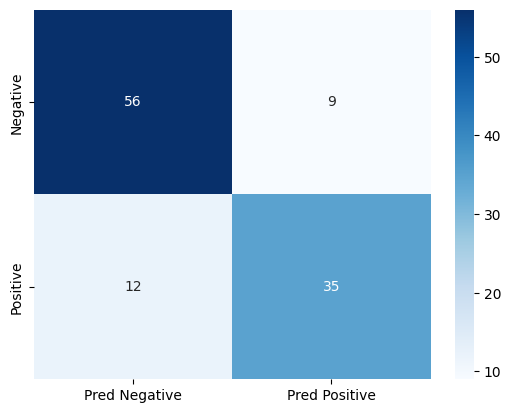

In [16]:
cols = ['brand', 'name', 'image_type', 'euclidean', 'cosine']
dicts = {col:[] for col in cols}

brands = ['adidas', 'puma', 'nike']

matches_df = get_similarity(brands)
f1, acc, precision, recall, specificity = get_metrics(matches_df, 0.86)